In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay



In [21]:
df = pd.read_csv("cleaned_booking_data.csv")

In [23]:
X = df.drop(columns=["booking status_Not_Canceled"])
y = df["booking status_Not_Canceled"]

In [25]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #fit(calculate mean and std) and scale
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test) 

In [29]:
X_train_scaled.shape

(28998, 27)

In [31]:
model  = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation="relu"),
    Dropout(0.3),  # 30% dropout; you can adjust this rate
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [35]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3, 
    restore_best_weights=True
)

In [37]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1 #show progress bar
)

Epoch 1/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7562 - loss: 0.5085 - val_accuracy: 0.8132 - val_loss: 0.4116
Epoch 2/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8115 - loss: 0.4161 - val_accuracy: 0.8193 - val_loss: 0.3950
Epoch 3/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8196 - loss: 0.3986 - val_accuracy: 0.8204 - val_loss: 0.3891
Epoch 4/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8212 - loss: 0.3945 - val_accuracy: 0.8246 - val_loss: 0.3830
Epoch 5/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8254 - loss: 0.3910 - val_accuracy: 0.8259 - val_loss: 0.3793
Epoch 6/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8280 - loss: 0.3815 - val_accuracy: 0.8268 - val_loss: 0.3754
Epoch 7/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8274 - loss: 0.3797 - val_accuracy: 0.8301 - val_loss: 0.3716
Epoch 8/20
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8302 - loss: 0.3731 - val_accuracy: 0.

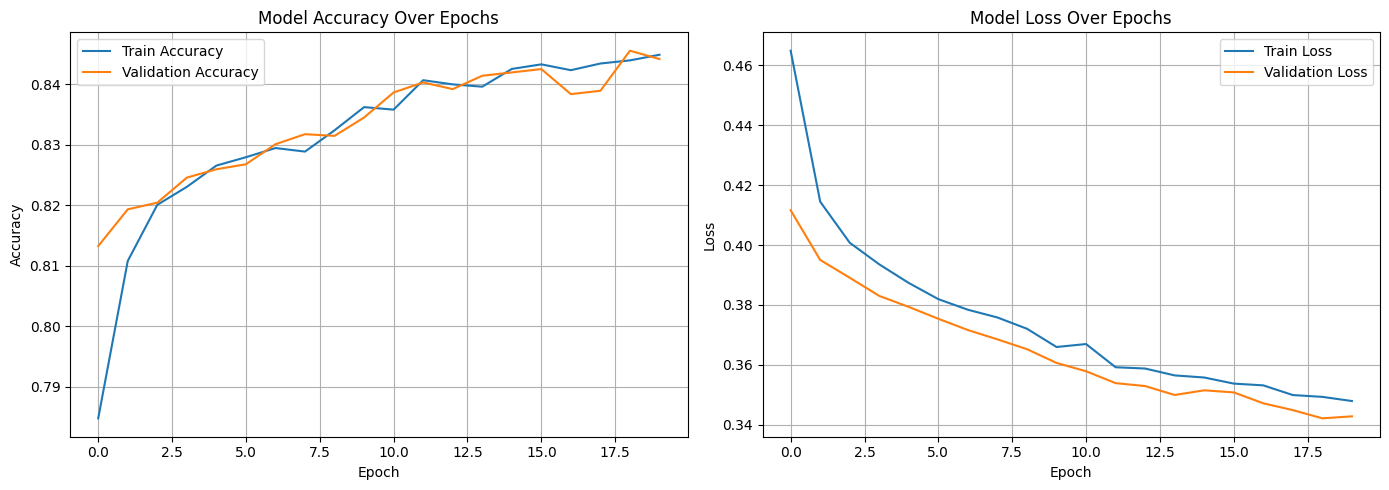

In [39]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8486 - loss: 0.3413


In [43]:
y_pred_probs = model.predict(X_test_scaled).ravel()


114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


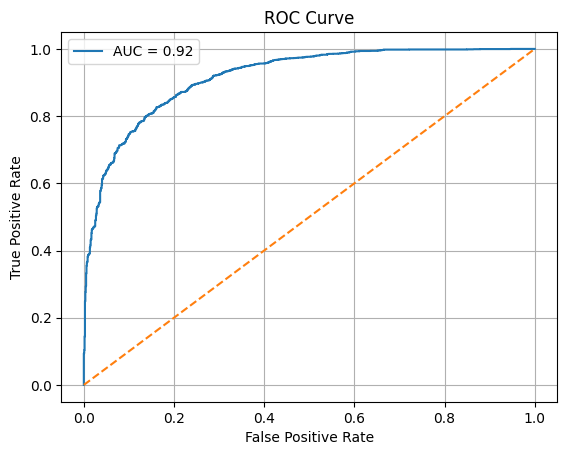

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


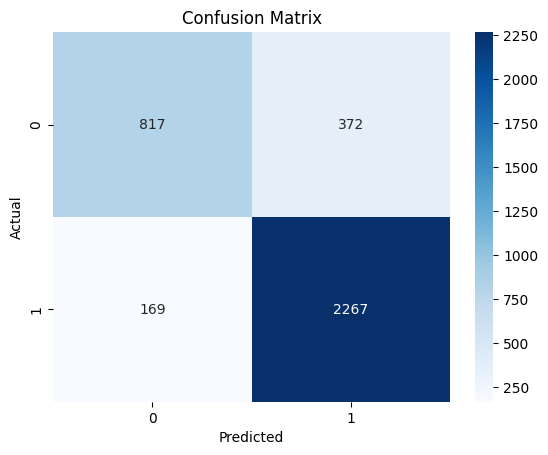

In [47]:
y_pred = (y_pred_probs > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
model.export("booking_model_tf")

INFO:tensorflow:Assets written to: booking_model_tf\assets


INFO:tensorflow:Assets written to: booking_model_tf\assets


Saved artifact at 'booking_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 27), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2131367181968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2131367176016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2131367180240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2131367173520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2131367177168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2131367177744: TensorSpec(shape=(), dtype=tf.resource, name=None)
